<a href="https://colab.research.google.com/github/jettecampbell/data-science/blob/main/Copy_of_Unit8ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 8 Exercises: The Art of BART

These exercises are grouped into two parts:

- Questions on the nature of decision trees, random forests, and BART models
- An oppurtunity to practice implementing and analyzing a BART model.

Enjoy!

## Bartian Theory

**Task1**:

Draw a decision tree--on a physical piece of paper--that predicts how many calories you burn in a day, using time you spent exercising that day (in minutes) as a predictor.

To help you understand what you're doing with this tree, seperately create an x/y plot with time exercising as x, and calories burned as y.

If this seems to easy, then add another variable or two (type of exercise?), and/or increase the depth of your tree.

You do not have to show me or turn in your tree to earn credit for this question, although I would like to see your drawing.

**Task2**:

What is a decision tree? How do they work?

A decision tree is a type of flowchart that makes predictions by splitting data into smaller groups based on feature values. It starts with a root node, selects the best feature to split on, and continues branching until reaching leaf nodes, which contain final predictions.

**Task3**:

What does the "depth" of a decision tree mean?

How do I know if a tree is too deep, or not deep enough?

The "depth" of a decision tree is how many levels are between the root node and the the deepest leaf node. A tree is too deep is it overfits the data and follows the data rather than patterns, and the tree is no deep enough if it fails to capture in relationship present in the data.

**Task4:**

How are BART models similar and different from a decision tree?

BART models are similar to decision trees because they use tree-based structures to make predictions. However, BART combines many small decision trees and uses Bayesian techniques to improve accuracy and uncertainty estimation. BART produces smoother predictions and avoids overfitting by averaging multiple tree-based models.

**Task5**:

Why would we use a BART model instead of a decision tree?

We use BART instead of a decision tree because BART provides better predictive performance and uncertainty quantification

## Bartian Penguins

**Task6**:

Create a BART model that uses flipper length, bill depth, and bill length to predict body mass in penguins, and make a ppc to check its fit

Code for loading the data is below. You'll need to do everything else yourself.

Remember to use my notes as a reference, and to copy and paste from them when it makes sense to.

Oh, and try a normal likelihood.

In [1]:
#drop the incomplete rows from the dat
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from sklearn import tree
!pip install pymc-bart
!pip install preliz
import pymc_bart as pmb
import preliz as pz
url="https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/penguins.csv"
penguins = pd.read_csv(url).dropna()

In [2]:
features = ["flipper_length", "bill_length","bill_depth"]

X = penguins[features]
Y = penguins["body_mass"].to_numpy()

In [3]:
with pm.Model() as model_octps:
    s = pm.HalfNormal('s',1000)
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50)
    μ = pm.Deterministic("μ",pm.math.exp(μ_))
    y = pm.Normal("y", mu=μ, sigma=s,  observed=Y)
    idata_octps = pm.sample(compute_convergence_checks=False)

Output()

Output()

<Axes: xlabel='y'>

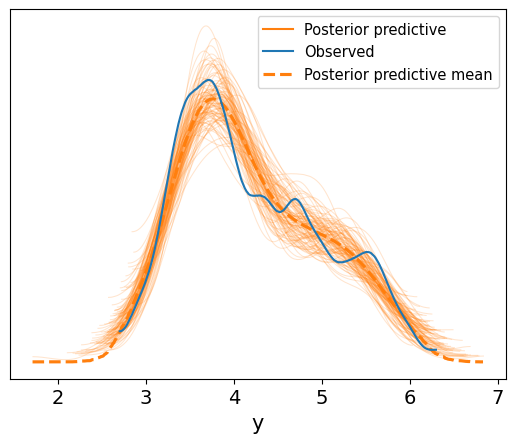

In [5]:
pm.sample_posterior_predictive(idata_octps,model_octps, extend_inferencedata=True)
az.plot_ppc(idata_octps, num_pp_samples=100, colors=["C1", "C0", "C1"])

**Task7**:

Plot flipper length versus body mass,

and then plot the posterior predictve from the model over the data.
You're going to copy paste the plotting code from the notes, fyi.

In [6]:
posterior_mean = idata_octps.posterior["μ"]

μ_hdi = az.hdi(ary=idata_octps, group="posterior", var_names=["μ"], hdi_prob=0.74)
pps = az.extract(
    idata_octps, group="posterior_predictive", var_names=["y"]
).T

In [7]:
Xn = X.to_numpy()

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


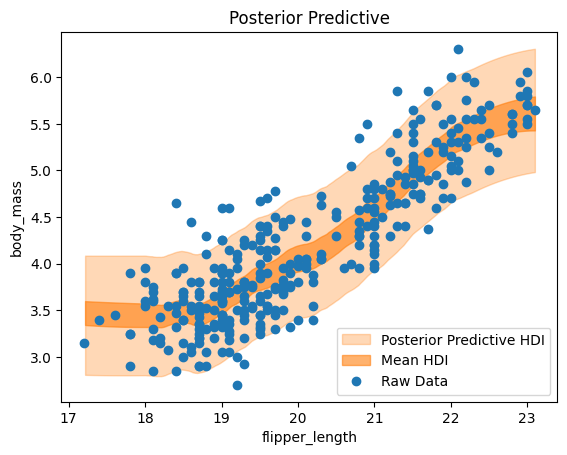

In [8]:
idx = np.argsort(Xn[:, 0])
fig, ax = plt.subplots()

az.plot_hdi(
    x=Xn[:, 0],
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive HDI"},
)

az.plot_hdi(
    x=Xn[:, 0],
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean HDI"},
)
ax.plot(penguins["flipper_length"], penguins["body_mass"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="flipper_length",
    ylabel="body_mass",
);

**Task8**:

Interpret the plot above in context. Do you think it captures the true association between flipper length and body mass in penguins? Why or why not? Make sure to reference specific things you see in the plot.

It looks like it does pretty well and the trend line captures most of the points. Although the higher points are not all hit by the posterior predictive, it mostly captures the association between flipper length and body mass.

**Task9**:

Create partial depnedence plots (pdps), individual conditional expectation (ice) plots, and a variable importance plot for the BARTpenguin model.

array([<Axes: xlabel='flipper_length'>, <Axes: xlabel='bill_length'>,
       <Axes: xlabel='bill_depth'>], dtype=object)

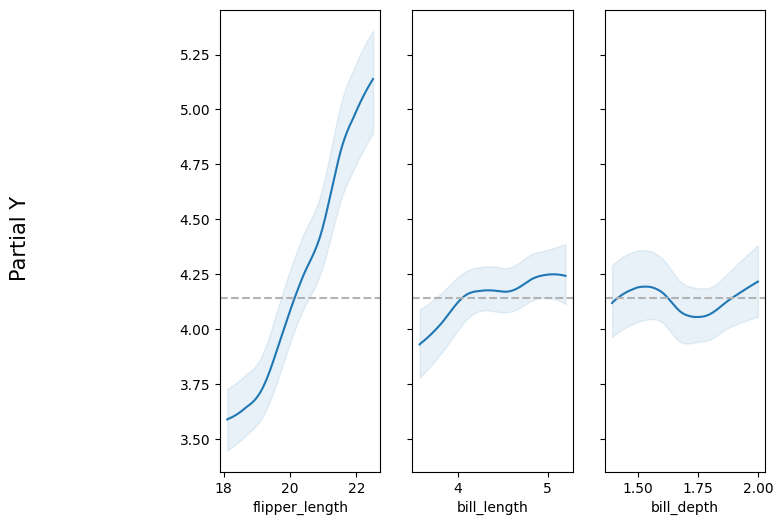

In [9]:
pmb.plot_pdp(μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

array([<Axes: xlabel='flipper_length'>, <Axes: xlabel='bill_length'>,
       <Axes: xlabel='bill_depth'>], dtype=object)

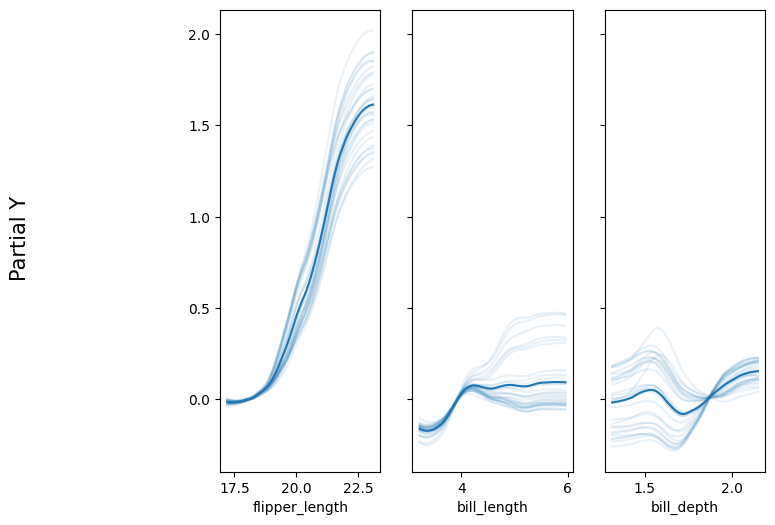

In [10]:
pmb.plot_ice( μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

<Axes: ylabel='R²'>

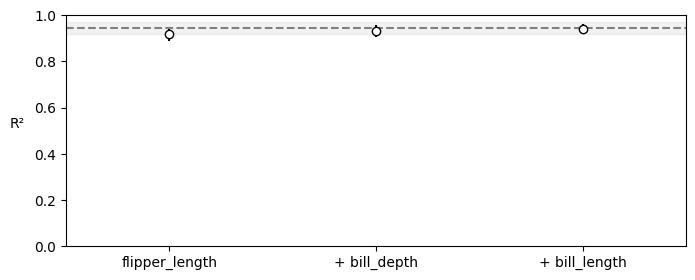

In [11]:
vi_counties = pmb.compute_variable_importance(idata_octps, μ_, X)
pmb.plot_variable_importance(vi_counties)

**Task10**:

Using the above plots, make an argument about which variable(s) is/are most important in predicting body mass in penguins.

What is the relationship for each variable to body mass, when you take the other variables into account?

Is that relationship complicated by interactions between variables? How do you know?

Make sure to reference specific things you see in each plot, to justify your decisions and comments.

Flipper length show the highest correlation, as shown by the slope being most impactful in the ice and pdp plots. However, it also demonstrates that there is some association between the other two, but not as much as there is with flipper length. The slopes of the depth and bill length graphs also vary, which supports the possibility that there is more going on with these two variables and may provide information about potential interactions or additional variables.